# Introduction

This workbook fits a Gaussian Process model to the Random and Sobol data. 

In [106]:
import GPy
import pandas as pd
import patsy as pt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
import re
import pymc3 as pm
import matplotlib.ticker as tk
import re
from sklearn.model_selection import KFold

In [107]:
df = pd.read_csv('results/all_results_average.csv')


df = df.rename(columns={'lag_time': 't', 'n_components': 'm', 'n_clusters': 'n', 'test_score': 'y'}).\
loc[:, ['basis', 'method', 'y', 't', 'm', 'n']]

to_scale = ['m', 'n', 't']
scaler = preprocessing.MinMaxScaler()
vars_scaled = pd.DataFrame(scaler.fit_transform(df.loc[:, to_scale]), columns=[x+'_s' for x in to_scale])
df = df.join(vars_scaled)

In [108]:
df.groupby(['method', 'basis']).count()

y    t    m    n  m_s  n_s  t_s
method   basis                                          
bayesian all_tor       192  192  192  192  192  192  192
         alpha_angle   191  191  191  191  191  191  191
         ca_cont       199  199  199  199  199  199  199
         chi_tor       198  198  198  198  198  198  198
         close-h_cont  200  200  200  200  200  200  200
         close_cont    200  200  200  200  200  200  200
         hb_pairs      191  191  191  191  191  191  191
         kappa_angle   196  196  196  196  196  196  196
random   all_tor       199  199  199  199  199  199  199
         alpha_angle   197  197  197  197  197  197  197
         ca_cont       199  199  199  199  199  199  199
         chi_tor       218  218  218  218  218  218  218
         close-h_cont  200  200  200  200  200  200  200
         close_cont    199  199  199  199  199  199  199
         drid          200  200  200  200  200  200  200
         ff_all_ang    200  200  200  200  200  200  200
         ff_bb_ang     200  200  200  200  200  200  200
         ff_re_ang     200  200  200  200  200  200  200
         hb_pairs      199  199  199  199  199  199  199
         kappa_angle   200  200  200  200  200  200  200
         ppo_tor       149  149  149  149  149  149  149
sobol    all_tor       197  197  197  197  197  197  197
         alpha_angle   196  196  196  196  196  196  196
         ca_cont       198  198  198  198  198  198  198
         chi_tor       200  200  200  200  200  200  200
         close_cont    200  200  200  200  200  200  200
         hb_pairs      197  197  197  197  197  197  197
         kappa_angle   162  162  162  162  162  162  162
tpe      all_tor       198  198  198  198  198  198  198
         alpha_angle   198  198  198  198  198  198  198
         ca_cont       198  198  198  198  198  198  198
         chi_tor       198  198  198  198  198  198  198
         close_cont    197  197  197  197  197  197  197
         hb_pairs      199  199  199  199  199  199  199
         kappa_angle   200  200  200  200  200  200  200

In [109]:
basis = 'all_tor'
idx = (df['basis'] == basis) & (df['method'].isin(['random'])) 
X = df.loc[idx, :].filter(regex='_s$')
y = df.loc[idx, 'y']

In [110]:
X_c = pt.dmatrix('0 + t_s + C(m_s) + n_s', data=X, return_type='dataframe')
X_c = X_c.rename(columns=lambda x: re.sub('C|\\(|\\)|\\[|\\]','',x))
X_c = X_c.rename(columns=lambda x: x[:10])
# X_c = X_c.iloc[:, 1:X_c.shape[1]] # Remove intercept

In [111]:
X_c.head()

,m_s0.0,m_s0.11111,m_s0.22222,m_s0.33333,m_s0.44444,m_s0.55555,m_s0.66666,m_s0.77777,m_s0.88888,m_s1.0,t_s,n_s
1567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.861723,0.418769
1568,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.119238,0.662967
1569,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.505010,0.575177
1570,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.889780,0.622603
1571,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.761523,0.929364


## Priors

In [112]:
def gamma(alpha, beta):
    def g(x):
        return pm.Gamma(x, alpha=alpha, beta=beta)
    return g

def hcauchy(beta):
    def g(x):
        return pm.HalfCauchy(x, beta=beta)
    return g


In [113]:
l_priors = [(1, 0.01), (1, 0.05), (1, 0.1)]
e_priors = [3, 2, 1]
s_priors = [3, 2, 1]

### Gamma - length scales

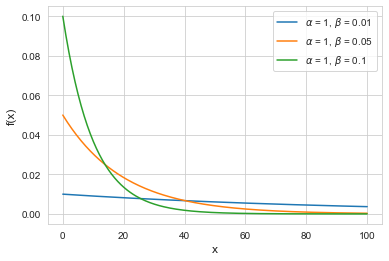

In [114]:
import scipy.stats as st
x = np.linspace(0, 100, 200)
# alphas = [1., 2., 3., 7.5]
# betas = [.5, .5, 1., 1.]
for a, b in l_priors:
    pdf = st.gamma.pdf(x, a, scale=1.0/b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)

### Half-Cauchy - Variance parameters

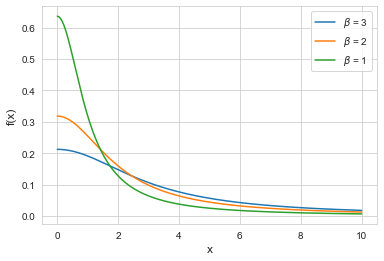

In [115]:
x = np.linspace(0, 10, 200)
for b in e_priors:
    hc = pm.HalfCauchy.dist(beta=b)
    pdf = np.exp(hc.logp(value=x).eval())
    plt.plot(x, pdf, label=r'$\beta$ = {}'.format(b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)

## Compare kernels

Using `fit_model_1`:

    1. RBF with `m` continuous
    2. RBF with `m` categorical - use code for model `1`
    3. Exponential with `m` categorical. 


In [116]:
def fit_model_1(y, X, kernel_type='rbf'):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use
    
    X, y are dataframes. We'll use the column names. 
    """
    with pm.Model() as model:
        # Covert arrays
        X_a = X.values
        y_a = y.values
        X_cols = list(X.columns)
        
        # Globals
        prop_Xu = 0.1
        l_prior = gamma(1, 0.05)
        eta_prior = hcauchy(2)
        sigma_prior = hcauchy(2)

        # Kernels
        # 3 way interaction
        eta = eta_prior('eta')
        cov = eta**2
        for i in range(X_a.shape[1]):
            var_lab = 'l_'+X_cols[i]
            if kernel_type=='RBF':
                cov = cov*pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='Exponential':
                cov = cov*pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='M52':
                cov = cov*pm.gp.cov.Matern52(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='M32':
                cov = cov*pm.gp.cov.Matern32(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

        # Covariance model
        cov_tot = cov 

        # Model
        gp = pm.gp.MarginalSparse(cov_func=cov_tot, approx="FITC")

        # Noise model
        sigma_n =sigma_prior('sigma_n')

        # Inducing variables
        num_Xu = int(X_a.shape[0]*prop_Xu)
        Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)

        # Marginal likelihood
        y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a,Xu=Xu, noise=sigma_n)
        mp = pm.find_MAP()
        
    return gp, mp, model

In [ ]:
# Inputs
exp_labs = ['Continuous', 'Continuous', 'Continuous', 'Continuous', 'Categorical', 'Categorical', 'Categorical', 'Categorical']
predictors = [X, X,X, X, X_c, X_c, X_c, X_c]
targets = [y, y, y, y,y, y, y, y]
kernels = ['RBF', 'Exponential', 'M52', 'M32', 'RBF','Exponential', 'M52', 'M32' ]

# Outputs
pred_dfs = []

# iterator
kf = KFold(n_splits=10)

for i in range(len(exp_labs)):
    
    for idx, (train_idx, test_idx) in enumerate(kf.split(X.values)):
        # subset dataframes
        y_train = targets[i].iloc[train_idx]
        X_train = predictors[i].iloc[train_idx, :]
        y_test = targets[i].iloc[test_idx]
        X_test = predictors[i].iloc[test_idx, :]  
        
        gp, mp, model = fit_model_1(y=y_train, X=X_train, kernel_type=kernels[i])

        # Test
        with model:
            # predict latent
            mu, var = gp.predict(X_test.values, point=mp, diag=True,pred_noise=False)
            sd_f = np.sqrt(var)
            # predict target
            _, var = gp.predict(X_test.values, point=mp, diag=True,pred_noise=True)
            sd_y = np.sqrt(var)
            
        res = pd.DataFrame({'f_pred': mu, 'sd_f': sd_f, 'sd_y': sd_y, 'y': y_test.values})
        res.loc[:, 'kernel'] = kernels[i]
        res.loc[:, 'm_type'] = exp_labs[i]
        res.loc[:, 'fold_num'] = idx
        
        pred_dfs.append(pd.concat([X_test, res], axis=1))

pred_dfs = pd.concat(pred_dfs)
    
        
    

INFO (theano.gof.compilelock): Refreshing lock /Users/robertarbon/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
INFO (theano.gof.compilelock): Refreshing lock /Users/robertarbon/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
logp = 48.705, ||grad|| = 0.38069: 100%|██████████| 28/28 [00:00<00:00, 193.92it/s]  
logp = 45.051, ||grad|| = 3.8043: 100%|██████████| 29/29 [00:00<00:00, 113.42it/s]  
INFO (theano.gof.compilelock): Refreshing lock /Users/robertarbon/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i

INFO (theano.gof.compilelock): Refreshing lock /Users/robertarbon/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/robertarbon/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
logp = 12.262, ||grad|| = 0.011991: 100%|██████████| 50/50 [00:00<00:00, 130.28it/s] 
 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
INFO (theano.gof.compilelock): Refreshing lock /Users/robertarbon/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/robe

In [ ]:
null_mu = np.mean(y)
null_sd = np.std(y)

def ll(f_pred, sigma_pred, y_true):
    tmp = 0.5*np.log(2*np.pi*sigma_pred**2)
        tmp += (f_pred-y_true)**2/(2*sigma_pred**2)
    return tmp

sll = ll(pred_dfs['f_pred'], pred_dfs['sd_y'], pred_dfs['y'])
sll = sll - ll(null_mu, null_sd, pred_dfs['y'])
pred_dfs['msll'] = sll
pred_dfs['smse'] = (pred_dfs['f_pred']-pred_dfs['y'])**2/np.var(y)



In [ ]:
pred_dfs.to_pickle('results/{}_gp_cross_validation.p'.format(basis))

In [ ]:
msll = pred_dfs.groupby(['m_type', 'kernel'])['msll'].mean()
sns.barplot(x='m_type', y='msll', hue='kernel', data=msll.reset_index())

In [ ]:
smse = pred_dfs.groupby(['m_type', 'kernel'])['smse'].mean()
sns.barplot(x='m_type', y='smse', hue='kernel', data=smse.reset_index())

In [ ]:
summary = pd.DataFrame(smse).join(other=pd.DataFrame(msll), on=['m_type', 'kernel'], how='left')
summary.to_csv('results/{}_gp_fit_summary.csv'.format(basis))

## Relevance distribution

In [ ]:
def fit_model_2(y, X, kernel_type='M32', n=1000, n_chains=2):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use
    
    X, y are dataframes. We'll use the column names. 
    """
    with pm.Model() as model:
        # Covert arrays
        X_a = X.values
        y_a = y.values
        X_cols = list(X.columns)
        
        # Globals
        prop_Xu = 0.1
        l_prior = gamma(1, 0.05)
        eta_prior = hcauchy(2)
        sigma_prior = hcauchy(2)

        # Kernels
        # 3 way interaction
        eta = eta_prior('eta')
        cov = eta**2
        for i in range(X_a.shape[1]):
            var_lab = 'l_'+X_cols[i]
            if kernel_type=='RBF':
                cov = cov*pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='Exponential':
                cov = cov*pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='M52':
                cov = cov*pm.gp.cov.Matern52(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='M32':
                cov = cov*pm.gp.cov.Matern32(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

        # Covariance model
        cov_tot = cov 

        # Model
        gp = pm.gp.MarginalSparse(cov_func=cov_tot, approx="FITC")

        # Noise model
        sigma_n =sigma_prior('sigma_n')

        # Inducing variables
        num_Xu = int(X_a.shape[0]*prop_Xu)
        Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)

        # Marginal likelihood
        y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a,Xu=Xu, noise=sigma_n)
        trace = pm.sample(draws=n, chains=n_chains, cores=1)
        
    return gp, trace, model

In [ ]:
gp, trace, model = fit_model_2(y=y, X=X, kernel_type='M32')


In [ ]:
df_trace = pd.DataFrame({x : trace.get_values(x) for x in trace.varnames if x[-5:]!='log__'})
df_trace.head()

In [ ]:
df_trace = pd.DataFrame({x : trace.get_values(x) for x in trace.varnames if x[-5:]!='log__'})
df_trace.columns = [r'$\eta$',r'$m$', r'$n$', r'$\tau$', r'$\sigma_n$']
df_trace.head()

len_labs = [ r'$\tau$', r'$m$', r'$n$']

relevance = pd.DataFrame(1/df_trace.loc[:, len_labs].values, columns=len_labs)
relevance_m = relevance.melt(var_name='Hyperparameter', value_name='Relevance')
with sns.plotting_context('paper', font_scale=1.25):
    sns.set_style('whitegrid')
    ax = sns.boxplot(data=relevance_m, x='Relevance', y='Hyperparameter', whis=2)
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(tk.StrMethodFormatter('{x:4.2f}'))
    ax.xaxis.set_minor_locator(tk.LogLocator(base=10.0, subs='auto', numdecs=4))
    ax.tick_params(which='minor', axis='x', bottom=True, direction='in')
    plt.savefig('figures/{}_gp_bayes_relevance.png'.format(basis), dpi=450 )

In [ ]:
all_params = relevance.join(df_trace.loc[:, [r'$\eta$', r'$\sigma_n$']])

all_params.melt(var_name='Parameter').groupby('Parameter')['value'].\
aggregate(**{"Median": lambda x: "{:4.2f}".format(np.median(x)), 
             "95% CI": lambda x: "({0:4.2f}, {1:4.2f})".format(np.quantile(x, 0.025),np.quantile(x, 0.975))}).\
reset_index().\
to_csv('results/{}_gp_bayes_posterior.csv'.format(basis), index=False)


## Fit best Marginal Likelihood model

In [ ]:
gp, mp, model = fit_model_1(y=y, X=X, kernel_type='M32')


In [ ]:
m_new, n_new, t_new = np.meshgrid(np.linspace(0, 1, 10), np.linspace(0, 1, 20), np.linspace(0, 1, 20))

X_new = np.array([m_new.flatten(), n_new.flatten(), t_new.flatten()]).T

with model:
    # predict latent
    mu, var = gp.predict(X_new, point=mp, diag=True,pred_noise=True)
    mu, var2 = gp.predict(X_new, point=mp, diag=True,pred_noise=False)

pred_df = pd.DataFrame(X_new, columns=['m_s', 'n_s', 't_s'])
pred_df['y'] = mu
pred_df['y_err'] = 2*np.sqrt(var)
pred_df['f_err'] = 2*np.sqrt(var2)

pred_df['type'] = 'prediction'
obs_df = pd.DataFrame(X.values, columns=['m_s', 'n_s', 't_s'])
obs_df['y'] = y.values
obs_df['y_err'] = 0
obs_df['f_err'] = 0

obs_df['type'] = 'observed'
all_df = pd.concat([pred_df,obs_df], axis=0)
tmp = scaler.inverse_transform(all_df.loc[:, ['m_s', 'n_s', 't_s']])
all_df.loc[:, 'm'] = tmp[:, 0]
all_df.loc[:, 'n'] = tmp[:, 1]
all_df.loc[:, 't'] = tmp[:, 2]

# round
all_df.loc[:, 'm'] = np.round(all_df['m'], 0).astype(int)
all_df.loc[:, 'n'] = np.round(all_df['n'], 0).astype(int)
all_df.loc[:, 't'] = np.round(all_df['t'], 1)
all_df['t_cut'] = pd.cut(all_df['t'], 3, precision=1)



## Model fit y vs n by m and $\tau$

In [ ]:
# Make two separate plots
with sns.plotting_context(font_scale=2):
    lims = [-1, 5, 10]
    fname = 'figures/{0}_gp_fit-{1}.png'
    paths = [fname.format(basis, i) for i in range(len(lims)-1)]
    
    for i in range(1,len(lims)):
        samp = all_df.loc[(all_df['m']<=lims[i]) & (all_df['m']>lims[i-1]),  :]
        cols = {'prediction': sns.color_palette('colorblind')[0], 'observed': 'k'}
        hue_kws = {'marker': ['o', 'x'], 'ms': [5, 10]}
        g = sns.FacetGrid(data=samp, row='t_cut',col='m',hue='type', hue_kws=hue_kws, palette=cols, margin_titles=False)
        g.map(plt.errorbar, 'n', 'y', 'y_err', elinewidth=1, lw=0)
        g.map(plt.errorbar, 'n', 'y', 'f_err', elinewidth=2, lw=0)
        g.set_titles(r'$m$ = {col_name} | $\tau \in$ {row_name}')
        plt.savefig(paths[i-1], dpi=450, bbox_inches='tight')



## n vs m surface - MML

In [ ]:
with sns.plotting_context(font_scale=1.25):
    tmp = all_df.loc[(all_df['type']=='prediction') & (np.abs(all_df['t_s']-np.linspace(0, 1, 20)[10])<0.001), 
               ['m', 'n', 'y']].pivot(index='n', columns='m', values='y')
    fig, ax = plt.subplots(1, figsize=(8,6))
    sns.heatmap(tmp, cmap='viridis', square=True, yticklabels=1, annot=True, fmt="3.1f", ax=ax)
    plt.savefig('figures/{}_gp_predictions_tau-median.png'.format(basis), dpi=450, bbox_inches='tight')

## Pred vs obs

In [ ]:
with model:
# predict latent
    mu, var = gp.predict(X.values, point=mp, diag=True,pred_noise=True)
    mu, var2 = gp.predict(X.values, point=mp, diag=True,pred_noise=False)

In [ ]:
with sns.plotting_context(font_scale=1.25):
    lims = (1.1, 2.4)
    cols = sns.color_palette('colorblind')    
    fig, ax = plt.subplots(1)
    ax.errorbar(y.values, mu, 2*np.sqrt(var),  color=cols[0], alpha=0.5, marker='o',
                label='$y(X) = f(X) + \sigma_n$', lw=0, elinewidth=1)
    ax.errorbar(y.values, mu, 2*np.sqrt(var2), color=cols[0], marker='o',
                label='$f(X)$', lw=0, elinewidth=2, alpha=0.8)
    ax.plot(lims, lims, label='$y=x$', color='k')
    ax.set_ylim(lims)
    ax.set_xlim(lims)
    ax.legend(bbox_to_anchor=(1,1))
    ax.set_ylabel('y (predicted)')
    ax.set_xlabel('y (observed)')
    plt.savefig('figures/{}_gp_pred-vs-obs.pdf'.format(basis), bbox_inches='tight')